<a href="https://colab.research.google.com/github/jaehyun0220/DL/blob/master/Naver%20Clip%20Analysis%20with%20Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

네이버 댓글 분석을 통한 상위, 하위 클립 예측

### #1. 구글 인증

In [230]:
# Auth 인증 및 Google Drive 활용 Data load
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


### #2. 입력 데이터셋 확인

In [231]:
!ls ../gdrive/My\ Drive/output

file_ep10.csv	 file_ep16.csv	file_ep22.csv  file_ep4.csv
file_ep11.csv	 file_ep17.csv	file_ep23.csv  file_ep5.csv
file_ep12.csv	 file_ep18.csv	file_ep24.csv  file_ep6.csv
file_ep13.csv	 file_ep19.csv	file_ep25.csv  file_ep7.csv
file_ep14_1.csv  file_ep1.csv	file_ep26.csv  file_ep8.csv
file_ep14.csv	 file_ep20.csv	file_ep2.csv   file_ep9.csv
file_ep15.csv	 file_ep21.csv	file_ep3.csv   TheLastEmpress.csv


### #3. 필요 패키지 Install

In [232]:
# !pip install regex # 정규식 적용을 위한 설치
!pip install konlpy # Okt, Kkma 등의 형태소 분석기 활용을 위한 설치
!pip install sacremoses sentencepiece # Bert 사용을 위한 Tokenizing을 위해 설치

### #4.라이브러리 로드

In [233]:
# 기본 라이브러리 로드
import pandas as pd
import numpy as np
import os, sys
import regex as re
import random

from tqdm import tqdm_notebook, trange, tqdm_pandas
tqdm_pandas(tqdm_notebook())
import tensorflow as tf

#데이터 전처리 관련 라이브러리 로드
from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences


#모델 평가를 위한 라이브러리 로드
from sklearn import metrics, model_selection
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

#데이터 분리를 위한 라이브러리 로드
from sklearn.model_selection import train_test_split

#수학 & 통계 관련 라이브러리 로드
import scipy.stats as st
from collections import Counter
import math

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Visualization
import seaborn as sns
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도


#Configure Visualization Defaults
#show plots in Jupyter Notebook browser
%matplotlib inline 
mpl.style.use('ggplot')
sns.set_style('white')

### #5. 입력 데이터 Load 및 데이터 정제, 타겟 분리

In [234]:
# crawling을 통해 수집한 네이버 clip 회차별 댓글 List
filelist = os.listdir('../gdrive/My Drive/output')

# 총 26회차 491개 하이라이트 클립 존재 (전체 재생수 = 107,221,654 / 클립 당 평균 재생수 = 218,374), 
# 이 중에서 예고편, 미공개, 인터뷰 등 클립 제외하고 총 422회 클립 대상 crawling 진행
df_title = pd.read_csv('../gdrive/My Drive/output/TheLastEmpress.csv', encoding = 'euc-kr')
df_title.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)

# 조회수 분포를 고려하여 각 회차별로 조회수 상위 4개, 하위 4개 클립을 샘플링 - 총 208개 클립
# 좋아요수, 댓글 수, 댓글 내용, 댓글 작성자 정보 (웹크롤링 통한 추출)

df_ep_tot = pd.DataFrame()

# 상위 하위 클립을 나누어 조회수 내림차순으로 rank를 매김 (1~4는 상위 클립, 5~8은 하위 클립)
for i in tqdm_notebook(filelist):
  if (i[:4] == 'file'):
    df_ep_temp = pd.read_csv('../gdrive/My Drive/output/'+i)
    df_ep_temp['play'] = df_ep_temp['play'].apply(lambda x: int(re.sub(',','', x[4:])))
    df_ep_temp['rank'] = df_ep_temp['play'].rank(method='dense', ascending=False)
    df_ep_tot = df_ep_tot.append(df_ep_temp)

# 크롤링 한 데이터에서 불필요한 열 삭제
df_ep_tot.drop(columns='Unnamed: 0', inplace=True)

# 상위 클립은 1로 하위 클립은 0으로 분류
df_ep_tot['target'] = np.where(df_ep_tot['rank']<=4,1,0)
df_ep_tot

nick                                           contents  ...  rank  target
0     rosi****  ㅅㅂ옷입고 목욕탕 들어가는거 ㅈㄴ웃기넼ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ저거 명품일 텐데ㅋㅋㅋㅋ...  ...   1.0       1
1       핑크에메랄드  왠지 선황제가 바람은 못폈을거 같다는 생각이 든다 태후가 황후로 있는한 감히 생각도...  ...   1.0       1
2          서지안                                           ㅋㅋㅋㅋㅋㅋㅋㅋ  ...   1.0       1
3            경                                                  ㅏ  ...   1.0       1
4           홍홍            이게 나라냐? 방송에서 이딴수위가 나오고 지랄이야 진짜 개좃헬조선 시발  ...   1.0       1
...        ...                                                ...  ...   ...     ...
1841     Major                                    와 ㅅㅂ...피지컬봐....  ...   8.0       0
1842      스폰지밥                              이쁘십니다 할때 나만설렜냐,,,,,,,  ...   8.0       0
1843       박한별                                                반했네  ...   8.0       0
1844       김민정                  죄송하지만 이 분 이용합시다 ! 어쨌든 좋은게 좋은거죠 ..  ...   8.0       0
1845      블링블링                                     우빈이한테 전부 들이대는군  ...   8.0       0

[40935 rows x 11 columns]

### #6. 데이터 정제 - 댓글 중 분석 대상이 되는 contens 내 null data 삭제

In [235]:
df_ep_sample = df_ep_tot.copy()
df_ep_sample.dropna(how='any', inplace=True)
df_ep_sample.info()
df_ep_sample['target'].value_counts() # 3:1 imbalanced dataset (조회수가 많은 클립에 댓글이 많기 때문임))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40801 entries, 0 to 1845
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   nick         40801 non-null  object 
 1   contents     40801 non-null  object 
 2   recomm       40801 non-null  int64  
 3   unrecomm     40801 non-null  int64  
 4   title        40801 non-null  object 
 5   play         40801 non-null  int64  
 6   like         40801 non-null  object 
 7   reple_count  40801 non-null  object 
 8   episode      40801 non-null  int64  
 9   rank         40801 non-null  float64
 10  target       40801 non-null  int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 3.7+ MB


1    30632
0    10169
Name: target, dtype: int64

###7. 데이터 정제 - 정규식 & 형태소 분석

In [236]:
df_ep_sample['contents'] = df_ep_sample['contents'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df_ep_sample.dropna(how='any', inplace=True)
df_sample_final = df_ep_sample.sample(frac=0.5).copy()
df_sample_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20400 entries, 690 to 484
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   nick         20400 non-null  object 
 1   contents     20400 non-null  object 
 2   recomm       20400 non-null  int64  
 3   unrecomm     20400 non-null  int64  
 4   title        20400 non-null  object 
 5   play         20400 non-null  int64  
 6   like         20400 non-null  object 
 7   reple_count  20400 non-null  object 
 8   episode      20400 non-null  int64  
 9   rank         20400 non-null  float64
 10  target       20400 non-null  int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 1.9+ MB


##8. 벡터 길이 산정을 위한 분포 체크

In [237]:
import konlpy
from konlpy.tag import Okt
from konlpy.utils import pprint

okt = Okt()

def morphs_okt(x):
  res = okt.morphs(x)
  if len(res) >= 1:
    res = [re.sub('[ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣ ]', '', res[i]) for i in range(len(res)) if re.sub('[ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣ ]', '', res[i]) != '' and len(res[i]) >= 1]
  else:
    res = ''
  res = '' if not res else res
  return res

df_sample_final['okt_token'] = df_sample_final['contents'].progress_apply(lambda x: morphs_okt(x))
df_sample_final.head()

nick  ...                                          okt_token
690        정민지  ...              [와, 오늘, 둘, 이, 진짜, 대박, 이, 였다, 진심, 멋있어]
222      황후의품격  ...         [그저, 갓, 보장, 갓, 꼴, 아, 봐, 꿀, 발성, 꿀, 보이스, 보소]
790   jpma****  ...  [아니, 왜케, 다, 들, 악역, 에, 몰입, 하, 나, 가정, 환경, 불우하, 신...
578   naej****  ...                                [오늘, 조금, 고구마, 내려가네]
1318        봉봉  ...                   [오이, 커플, 낮, 에, 뜨는, 달, 드라마, 찍어주요]

[5 rows x 12 columns]

(array([1.2381e+04, 5.1650e+03, 1.4560e+03, 6.1100e+02, 3.3600e+02,
        1.5500e+02, 8.5000e+01, 5.9000e+01, 4.3000e+01, 2.7000e+01,
        1.6000e+01, 1.3000e+01, 6.0000e+00, 1.5000e+01, 1.3000e+01,
        8.0000e+00, 8.0000e+00, 2.0000e+00, 0.0000e+00]),
 array([  0.  ,   9.25,  18.5 ,  27.75,  37.  ,  46.25,  55.5 ,  64.75,
         74.  ,  83.25,  92.5 , 101.75, 111.  , 120.25, 129.5 , 138.75,
        148.  , 157.25, 166.5 , 175.75]),
 <a list of 19 Patch objects>)

33.0


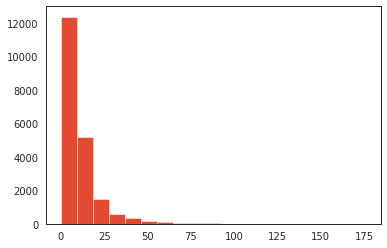

In [238]:
# token의 Histogram 분포를 바탕으로 대부분의 단어 길이 cover 가능한 단어 개수 찾기 for MAX_LEN
# # 신경망 학습을 위한 input 벡터 길이로 사용 - 적정 길이는 tokenizng 이후 분포를 보고 결정(코드 하단)
totalLenSent = [len(x) for x in df_sample_final['okt_token']] # 각 document의 단어 길이를 check
plt.hist(totalLenSent,bins = np.arange(0,max(totalLenSent),max(totalLenSent)/20))
print(np.percentile(totalLenSent, 95)) # 95%를 커버하는 수치는 31

In [239]:
# # input data 원문에서 보존할 최대 단어 개수 for MAX_FEATURES
# # 전체 데이터셋에서 나타나는 unique 한 단어 수(넉넉하게 백단위 올림하여 setting)
from itertools import chain

sum_lists = list(chain.from_iterable(df_sample_final['okt_token']))
totalCntWords = int(math.ceil(len(set(sum_lists))/100)*100)
print(totalCntWords)

26200


### 9. Word Embedding을 위한 Hyper parameter Tuning

In [240]:
# Hyper Param setting

# MAX_LEN = int(np.percentile(totalLenSent, 95))
MAX_LEN = 64 # 벡터길이 32면 충분히 cover 가능하지만 Bert는 128 embedding을 사용

# pre-trained Embedding을 몇 개 사용할 지 결정
NUM_MODELS = 1

# MAX_FEATURES = totalCntWords
MAX_FEATURES = 26000

###10. 데이터를 Bert 친화 형식으로 변경

In [241]:
# Bert 친화 형식으로 변경
all_df_bert = pd.DataFrame({
    'id':range(len(df_sample_final)), 
    'label':df_sample_final['target'], 
    'alpha':['a']*df_sample_final.shape[0], # 더미 컬럼이나 BERT Training을 위해 필요
    'text': df_sample_final['contents'].replace(r'\n', ' ', regex=True)
})
display(all_df_bert.head())

id  label alpha                                  text
690    0      1     a               와오늘 둘이 진짜 대박이였다 진심멋있어ㅠㅠ
222    1      1     a                그저 갓보장갓꼴아봐 꿀발성 꿀보이스 보소
790    2      1     a  아니 왜케 다들 악역에 몰입하나가정환경불우하신분들이 많이 보는건가
578    3      1     a                        오늘 조금 고구마 내려가네
1318   4      1     a                오이커플 낮에뜨는달드라마찍어주요 ㅠㅠㅠㅠ

In [242]:
# 시간이 오래 걸리는 작업을 피하기 위해 임시 저장
all_df_bert.to_csv('../gdrive/My Drive/data/bert/all.tsv', sep='\t', index=False, header=False)

### #8. 데이터를 불러와 Tokenizing 준비

In [243]:
# Create sentence and label lists
df_all = pd.read_csv("../gdrive/My Drive/data/bert/all.tsv", delimiter='\t', header=None, names = ['id', 'label', 'alpha', 'text'])
print(df_all.shape)
df_all[df_all["id"]==0] # 정상 loading check

(20400, 4)


id  label alpha                     text
0   0      1     a  와오늘 둘이 진짜 대박이였다 진심멋있어ㅠㅠ

In [244]:
sentences = df_all.text.values
# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = df_all.label.values
len(sentences)

20400

### #9. Pytorch 환경 내에서 BERT를 사용하기 위한 BERT 관련 Library Load

In [245]:
!pip install torch==1.4.0
!pip install transformers==3.5.1

In [246]:
import sacremoses
import sentencepiece

import pickle
import shutil
from joblib import Parallel, delayed

import torch
import torch.nn as nn # for neural net
import torch.utils.data
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss

from IPython.core.interactiveshell import InteractiveShell # jupyter에서 마지막 값만 출력하는게 아니라 모든 출력값을 매번 연속적으로 출력
InteractiveShell.ast_node_interactivity = "all" # all, last, last_expr, none (기본값은 'last_expr')

# from transformers import convert_tf_checkpoint_to_pytorch
from transformers import convert_bert_original_tf_checkpoint_to_pytorch

from transformers import BertTokenizer, AdamW, BertModel, BertPreTrainedModel, BertConfig
from transformers.optimization import get_linear_schedule_with_warmup

from transformers import BertConfig # This is the Bert configuration file

### #10. Bert 학습을 위한 경로 설정

In [247]:
# !mkdir ./bert_work/
# PATH_PRETRAINED = "../gdrive/My Drive/data/bert/multi_cased_L-12_H-768_A-12/"
# PATH_TORCH_PRETRAINED = "../gdrive/My Drive/data/bert/bert-base-multilingual-cased/"
# PATH_HUGGING = "../gdrive/My Drive/data/bert/huggingface/"
# PATH_WORK = './bert_work/'
# sys.path.append(PATH_PRETRAINED)
# sys.path.append(PATH_WORK)

PATH_PRETRAINED = "../gdrive/My Drive/data/bert/bert-base-multilingual-cased"
PATH_VOCAB = "../gdrive/My Drive/data/bert/bert-base-multilingual-cased"
PATH_BERT = "../gdrive/My Drive/data/bert"
sys.path.append(PATH_PRETRAINED)
sys.path.append(PATH_BERT)

### #11. Bert 학습을 위한 pretrained model을 pytorch 형태로 변환하여 work 경로로 복사

In [248]:
# convert_bert_original_tf_checkpoint_to_pytorch.convert_tf_checkpoint_to_pytorch(
#     PATH_PRETRAINED + 'bert_model.ckpt',
#     PATH_PRETRAINED + 'bert_config.json',
#     PATH_TORCH_PRETRAINED + 'pytorch_model.bin')

# # 읽어온 BERT_MODEL_PATH bert_config.json file의 설정을 PATH_TORCH_PRETRAINED에 쓰고 복사 후 PATH_WORK의 bert_config.json이라는 이름으로 저장
# shutil.copyfile(PATH_PRETRAINED + 'bert_config.json', PATH_TORCH_PRETRAINED + 'config.json')
# shutil.copyfile(PATH_TORCH_PRETRAINED + 'config.json', PATH_WORK + 'config.json')
# shutil.copyfile(PATH_TORCH_PRETRAINED + 'pytorch_model.bin', PATH_WORK + 'pytorch_model.bin')
# # 읽어온 BERT_MODEL_PATH vocab.txt file의 설정을 그대로 PATH_WORK의 vocab.txt라는 이름으로 저장
# shutil.copyfile(PATH_PRETRAINED + 'vocab.txt', PATH_TORCH_PRETRAINED + 'vocab.txt')
# shutil.copyfile(PATH_TORCH_PRETRAINED + 'vocab.txt', PATH_WORK + 'vocab.txt')

# # 상기 내용 1회 시행 이후는 그냥 PATH_PRETRAINED의 변환 된 파일들을 PATH_WORK로만 복사
# shutil.copyfile(PATH_TORCH_PRETRAINED + 'config.json', PATH_WORK + 'config.json')
# shutil.copyfile(PATH_TORCH_PRETRAINED + 'pytorch_model.bin', PATH_WORK + 'pytorch_model.bin')
# shutil.copyfile(PATH_TORCH_PRETRAINED + 'vocab.txt', PATH_WORK + 'vocab.txt')

# 상기 내용 1회 시행 이후는 그냥 PATH_PRETRAINED의 변환 된 파일들을 PATH_WORK로만 복사
# shutil.copyfile(PATH_HUGGING + 'bert-base-multilingual-cased-config.json', PATH_WORK + 'config.json')
# shutil.copyfile(PATH_HUGGING + 'bert-base-multilingual-cased-pytorch_model.bin', PATH_WORK + 'pytorch_model.bin')
# shutil.copyfile(PATH_HUGGING + 'bert-base-multilingual-cased-vocab.txt', PATH_WORK + 'vocab.txt')

In [249]:
# ! cat ./bert_work/bert-base-multilingual-cased-config.json
# "url": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-pytorch_model.bin"

### #12. BERT 사용 관련 Hyperparameter Setting

In [250]:
seed = 42
MAX_SEQ_LEN = MAX_LEN # token분포 바탕으로 128 선정 (대부분의 단어 길이 cover)

NUM_LABELS = len(df_sample_final['target'].unique()) #2 If ``config.num_labels > 1`` a classification loss is computed (Cross-Entropy)
training_epochs = 5
lr = 2e-7
warmup = 0.05
batch_size = 32

bert_model_config = PATH_PRETRAINED+'/bert_config.json'

bert_model = 'bert-base-multilingual-cased'
do_lower_case = 'uncased' in bert_model
device = torch.device('cuda') # GPU 사용 setting

output_model_file = 'bert_pytorch.bin'
output_optimizer_file = 'bert_pytorch_optimizer.bin'

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [251]:
class BertForSequenceClassification(BertPreTrainedModel):
    r"""
        **labels**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size,)``:
            Labels for computing the sequence classification/regression loss.
            Indices should be in ``[0, ..., config.num_labels - 1]``.
            If ``config.num_labels == 1`` a regression loss is computed (Mean-Square loss),
            If ``config.num_labels > 1`` a classification loss is computed (Cross-Entropy).
    Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:
        **loss**: (`optional`, returned when ``labels`` is provided) ``torch.FloatTensor`` of shape ``(1,)``:
            Classification (or regression if config.num_labels==1) loss.
        **logits**: ``torch.FloatTensor`` of shape ``(batch_size, config.num_labels)``
            Classification (or regression if config.num_labels==1) scores (before SoftMax).
        **hidden_states**: (`optional`, returned when ``config.output_hidden_states=True``)
            list of ``torch.FloatTensor`` (one for the output of each layer + the output of the embeddings)
            of shape ``(batch_size, sequence_length, hidden_size)``:
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        **attentions**: (`optional`, returned when ``config.output_attentions=True``)
            list of ``torch.FloatTensor`` (one for each layer) of shape ``(batch_size, num_heads, sequence_length, sequence_length)``:
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.
    Examples::
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
        input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
        labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
        outputs = model(input_ids, labels=labels)
        loss, logits = outputs[:2]
    """
    def __init__(self, config):
        super(BertForSequenceClassification, self).__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, inputs_embeds=None, labels=None):

        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids,
                            head_mask=head_mask,
                            inputs_embeds=inputs_embeds)

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

### #13. Bert 형식으로 Tokenizing 시행
#### - 여기서는 직접 map을 이용해 직접 vocab을 다운로드

In [252]:
# tokenizer = BertTokenizer.from_pretrained(os.path.join(PATH_WORK, 'vocab.txt'), cache_dir=None, do_lower_case=do_lower_case, do_basic_tokenize=False)
# ['니', '##는', '[UNK]', '황', '##후', '##는', '이', '##짓', '##하면', '##안', '##돼', '##냐', '진', '##실을', '말', '##한', '##것', '뿐', '##인', '##데']

# OKT로 Tokenize 한 데이터를 string으로 붙인 뒤 이를 다시 bert 형태로 tokenizing
%%time
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=do_lower_case)

for i in range(0, len(sentences), 2000):
  sentence = sentences[i:(i+2000)] 
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentence]
  
  # 2000번에 한개씩 결과 출력 
  if (i % 2000) == 0:
    print(tokenized_texts)
    
  input_ids_tmp = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

  if i < 2:
    print(input_ids_tmp)

  input_ids_tmp = pad_sequences(input_ids_tmp, maxlen=MAX_LEN, dtype="long", truncating='post', padding='post')
  if i==0:
    input_ids = input_ids_tmp
    print(i)
  else:
    input_ids = np.vstack((input_ids, input_ids_tmp))
    print(i, '완료', input_ids.shape, input_ids_tmp.shape)

loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/vocab.txt from cache at /root/.cache/torch/transformers/eff018e45de5364a8368df1f2df3461d506e2a111e9dd50af1fae061cd460ead.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29


[['[CLS]', '와', '##오', '##늘', '둘', '##이', '진', '##짜', '대', '##박', '##이', '##였다', '[UNK]', '[SEP]'], ['[CLS]', '그', '##저', '갓', '##보', '##장', '##갓', '##꼴', '##아', '##봐', '꿀', '##발', '##성', '꿀', '##보', '##이스', '보', '##소', '[SEP]'], ['[CLS]', '아', '##니', '왜', '##케', '다', '##들', '악', '##역', '##에', '몰', '##입', '##하', '##나', '##가', '##정', '##환', '##경', '##불', '##우', '##하', '##신', '##분', '##들이', '많이', '보', '##는', '##건', '##가', '[SEP]'], ['[CLS]', '오', '##늘', '조', '##금', '고', '##구', '##마', '내', '##려', '##가', '##네', '[SEP]'], ['[CLS]', '오', '##이', '##커', '##플', '낮', '##에', '##뜨', '##는', '##달', '##드라마', '##찍', '##어', '##주', '##요', '[UNK]', '[SEP]'], ['[CLS]', '[UNK]', '[SEP]'], ['[CLS]', '맨', '##발', '##로', '막', '뛰', '##어', '나', '##가는', '##거', '써', '##니', '[UNK]', '[UNK]', '[SEP]'], ['[CLS]', '롤', '##러', '##코', '##스트', '##전', '##개', '[SEP]'], ['[CLS]', '지', '##진', '##혁', '그', '##만', '##때', '##려', '##요', '[UNK]', '[SEP]'], ['[CLS]', '영', '##상', '올', '##려', '##주시', '##는', '분', '그', '##것', '##도', '올

In [253]:
np.save('wordpiece_tokenize_128.npy', input_ids)
input_ids = np.load('wordpiece_tokenize_128.npy')
print(input_ids.shape)
input_ids[:1]

(20400, 64)


array([[   101,   9590,  28188, 118762,   9105,  10739,   9708, 119235,
          9069, 118963,  10739,  34776,    100,    102,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0]])

## 분류에 사용할 클래스 Load

In [254]:
X = input_ids
Y = labels

# Train & Test Set 분리
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [255]:
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(16320, 64) (4080, 64) (16320,) (4080,)


In [256]:
# Dataset을 상속한 TensorDataset은 train data x와 레이블 y를 묶어놓은 컨테이너로 tensor만 전달 가능함
# X는 torch.long 형태의 텐서로, y는 torch.float 타입의 텐서로 입력하여 pytorch에서 연산할 수 있는 기본 구조로 변경하여 train_dataset으로 할당
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_x,dtype=torch.long), torch.tensor(train_y,dtype=torch.long))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_x,dtype=torch.long), torch.tensor(test_y,dtype=torch.long))

print(train_x.shape)
print(train_y.shape)

(16320, 64)
(16320,)


In [257]:
train_losses = []

# Train 함수
def bert_train_net(net, train_loader, optimizer, device="cuda"):
  tq = tqdm_notebook(range(training_epochs))

  for epoch in tq:
    tr_loss = 0.
    nb_tr_examples, nb_tr_steps = 0,0

    # 신경망을 훈련 모드로 설정
    net.train()
    tk0 = tqdm_notebook(enumerate(train_loader),total=len(train_loader),leave=False)
    
    # iteration 1회에 train_loader의 batch_size (여기서는 64)만큼씩 읽어와 한꺼번에 batch처리 batch_size * i (여기서는 i = ) 가 전체 train data set의 크기가 될때까지 loop
    for i,(x, y) in tk0:
      x=x.to(device) # len(x)는 batch_size
      y=y.to(device)

      loss, logit = net(x, token_type_ids=None, attention_mask=(x>0).to(device), labels=y)  # forward

      optimizer.zero_grad() # step과 zero_grad는 쌍을 이루는 것이라고 생각하면 됨 # optimizer의 gradient를 0으로 초기화
      
      if (i%100) == 0:
        print("loss ... ", loss, type(loss))
        # print("logit ... ", logit, type(logit))
      train_losses.append(loss.item())

      loss.backward() # backpropagation
      optimizer.step() # update gradients

      # update tracking variables
      tr_loss += loss.item()
      nb_tr_examples += x.size(0)
      nb_tr_steps += 1
      # running_loss += loss.item() # loss calculate

      train_losses.append(tr_loss/nb_tr_steps)

    print("epoch: {}/{} | train_loss: {:.4f} ".format(epoch, training_epochs, tr_loss/nb_tr_steps))
    # train_losses.append(running_loss/len(train_loader))
    # torch.save(model.state_dict(), output_model_file)

In [258]:
# BertForSequenceClassification is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. 
# As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

# Load pre-trained model (weights)

CACHE_DIR = 'cache/'

model = BertForSequenceClassification.from_pretrained(bert_model, cache_dir=CACHE_DIR, num_labels=NUM_LABELS)
# model = BertForSequenceClassification.from_pretrained(PATH_WORK, num_labels=NUM_LABELS)
# model = BertForSequenceClassification.from_pretrained(CACHE_DIR + 'cased_base_bert_pytorch.tar.gz', cache_dir=CACHE_DIR, num_labels=num_labels)

param_optimizer = list(model.named_parameters())
print("before freezing - param_optimizer is: ", param_optimizer[:2])
# print(model.bert)
# print("*"*100)
# print(model.children)

# freeze all layers of bert and just train task based classifier
# for param in model.bert.parameters():
for name, param in param_optimizer:
    print("name = ", name, "param.requires_grad = ", param.requires_grad)
    if name.startswith("bert"):
      param.requires_grad = False
    else:
      param.requires_grad = True

print("after freezing - param_optimizer is: \n", param_optimizer[:2])

for name, param in param_optimizer:
    print("name = ", name, "param.requires_grad = ", param.requires_grad)

no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

### In Transformers, optimizer and schedules are splitted and instantiated like this:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters, lr=lr, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

loading configuration file https://huggingface.co/bert-base-multilingual-cased/resolve/main/config.json from cache at cache/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "type_vocab_size": 2,
  "vocab_size": 119547
}

loading weights file https://huggingface.co/bert-base-multili

before freezing - param_optimizer is:  [('bert.embeddings.word_embeddings.weight', Parameter containing:
tensor([[ 0.0260, -0.0062, -0.0041,  ...,  0.0297,  0.0242,  0.0197],
        [ 0.0104, -0.0136,  0.0067,  ...,  0.0124,  0.0267,  0.0337],
        [ 0.0221, -0.0036,  0.0193,  ...,  0.0069,  0.0268,  0.0050],
        ...,
        [ 0.0068,  0.0189,  0.0267,  ...,  0.0229,  0.0647,  0.0437],
        [ 0.0184,  0.0148,  0.0243,  ...,  0.0321,  0.0071,  0.0204],
        [ 0.0214,  0.0188, -0.0134,  ..., -0.0060,  0.0058, -0.0059]],
       requires_grad=True)), ('bert.embeddings.position_embeddings.weight', Parameter containing:
tensor([[-0.0233,  0.0062, -0.0114,  ...,  0.0174, -0.0090,  0.0058],
        [-0.0097, -0.0112,  0.0350,  ...,  0.0185, -0.0010, -0.0077],
        [-0.0058, -0.0043,  0.0217,  ...,  0.0068,  0.0048, -0.0032],
        ...,
        [ 0.0144,  0.0543, -0.0010,  ..., -0.0129, -0.0027,  0.0408],
        [ 0.0134,  0.0306, -0.0068,  ..., -0.0112, -0.0133,  0.0309],


In [259]:
# !ls ../gdrive/My\ Drive/data/bert/huggingface

In [260]:
model.to(device) # GPU 연산을 위해 cuda로 전송

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
bert_train_net(model, train_loader, optimizer, device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

loss ...  tensor(0.7259, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.7024, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6926, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6834, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6955, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6824, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
epoch: 0/5 | train_loss: 0.6978 


loss ...  tensor(0.6849, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6890, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.7030, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6782, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6924, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6979, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
epoch: 1/5 | train_loss: 0.6870 


loss ...  tensor(0.6686, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6838, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6685, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6735, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6574, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6819, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
epoch: 2/5 | train_loss: 0.6790 


loss ...  tensor(0.6795, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6791, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6799, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6930, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6556, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6672, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
epoch: 3/5 | train_loss: 0.6732 


loss ...  tensor(0.6978, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6739, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6754, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6712, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6826, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
loss ...  tensor(0.6737, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
epoch: 4/5 | train_loss: 0.6669 



<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Training loss')

Text(0.5, 0, 'Batch')

Text(0, 0.5, 'Loss')

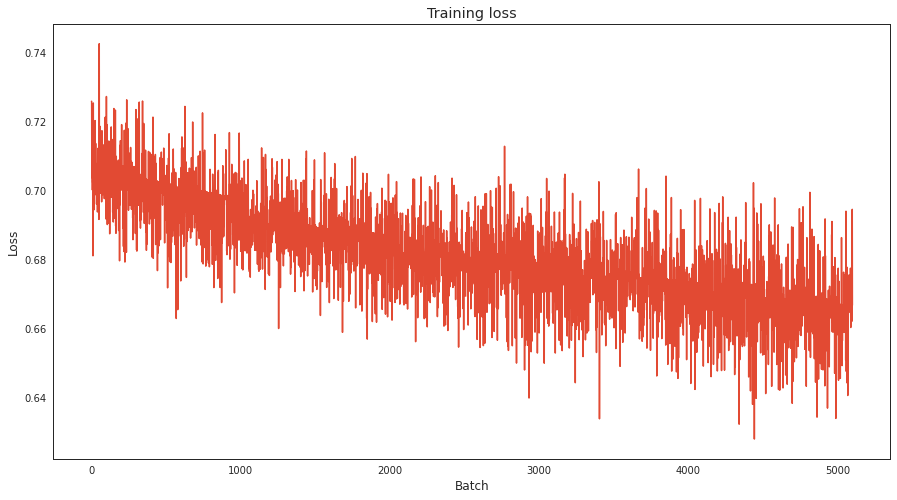

In [261]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_losses)
plt.show()

In [262]:
preds = []
labels = []

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(y_preds, real_ys):
    pred_flat = np.argmax(y_preds, axis=1).flatten()
    labels_flat = real_ys.flatten()
    print("pred_flat is ", pred_flat)
    print("labels_flat is ", labels_flat)
    preds.append(pred_flat)
    labels.append(labels_flat)
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [263]:
# 평가 헬퍼 함수
def bert_eval_net(net, data_loader, device="cuda"):
  # Dropout 및 BatchNorm 무효화
  net.eval()

  eval_acc = 0
  nb_eval_examples, nb_eval_steps = 0,0

  for x, y in data_loader:
    x=x.to(device)
    y=y.to(device)
    with torch.no_grad():
      y_preds = net(x, token_type_ids=None, attention_mask=(x>0).to(device), labels=None)  # forward

    #Move logits and labels to CPU
    y_preds = y_preds[0].detach().cpu().numpy()
    real_ys = y.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(y_preds, real_ys)
    print("tmp_eval_accuracy : ", tmp_eval_accuracy)

    eval_acc += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_acc/nb_eval_steps))

In [264]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
bert_eval_net(model, test_loader, device)

pred_flat is  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
labels_flat is  [1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
tmp_eval_accuracy :  0.78125
pred_flat is  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
labels_flat is  [1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1]
tmp_eval_accuracy :  0.71875
pred_flat is  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
labels_flat is  [1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1]
tmp_eval_accuracy :  0.71875
pred_flat is  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
labels_flat is  [1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1]
tmp_eval_accuracy :  0.65625
pred_flat is  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
labels_flat is  [0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 1 0 1 0 1]
tmp_eval_accuracy :  0.6875
pred_flat is  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [265]:
def result_summary(pred_y, real_y):
  print("Accuracy: {:.4f}".format(accuracy_score(real_y, pred_y)))
  print("Confusion Matrix: \n", confusion_matrix(real_y, pred_y))
  print("Classification Report Matrix: \n", classification_report(real_y, pred_y, digits=3))

  roc_auc = roc_auc_score(real_y, pred_y)
  print("roc_auc score is : {:.4f}".format(roc_auc))

  fpr, tpr, threshold = roc_curve(real_y, pred_y)
  roc_auc = auc(fpr, tpr)

  auc_graph(roc_auc, fpr, tpr)

def auc_graph(roc_auc, fpr, tpr):
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

### 최종 List를 하나의 List로 펴줌

Accuracy: 0.7426
Confusion Matrix: 
 [[   4 1018]
 [  32 3026]]
Classification Report Matrix: 
               precision    recall  f1-score   support

           0      0.111     0.004     0.008      1022
           1      0.748     0.990     0.852      3058

    accuracy                          0.743      4080
   macro avg      0.430     0.497     0.430      4080
weighted avg      0.589     0.743     0.641      4080

roc_auc score is : 0.4967


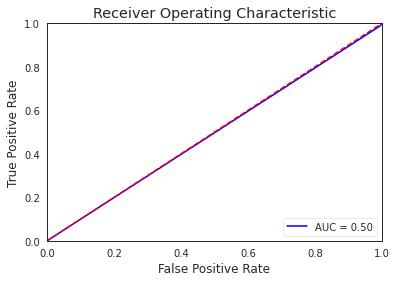

In [266]:
import itertools
preds_flat = list(itertools.chain(*preds))
labels_flat = list(itertools.chain(*labels))

result_summary(preds_flat, labels_flat)